# Spatial plots of tas/pr post Krakatoa eruption using CMIP6 historical model output
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files, calculates anomalies and generates spatial plots at different times over Australia.  


In [12]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [13]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [14]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [15]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302


In [16]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [17]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

46 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/tas/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gr1.5/v20190919/*.nc
Model MPI-ESM1-2-HR has different time so is now removed
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/tas/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/tas/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p1f1/Amon/tas/gr1.5/v20190818/*.nc
BCC-ESM1 

In [18]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

45 model paths found and loaded into the dictionary "models"
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/pr/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/pr/gr1.5/v20190630/*.nc
Path for MCM-UA-1-0 does not exist
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/pr/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr1.5/v20180803/*.nc
CAS-ESM2-0 /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5/v20200302/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Amon/pr/gr1.5/v20190927/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/CMIP/CAS/FGOALS-g3/historical/r1i1p

In [19]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [20]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,9.35 GB,1.38 MB
Shape,"(41, 1980, 120, 240)","(1, 12, 120, 240)"
Count,34445 Tasks,6765 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,18.70 GB,2.76 MB
Shape,"(41, 1980, 120, 240)","(1, 12, 120, 240)"
Count,42202 Tasks,6765 Chunks
Type,float64,numpy.ndarray


In [21]:
# get rid of models with issues
models = models.drop_sel(model=['CIESM'])

In [22]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 40 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-SR5' 'CanESM5' 'E3SM-1-1'
 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3'
 'FIO-ESM-2-0' 'GFDL-CM4' 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC'
 'GISS-E2-1-H' 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G'
 'MIROC6' 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out time around Krakatoa eruption

In [23]:
models = models.sel(time = slice('1850-01','1900-01'))

## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [24]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [25]:
# import land fraction data
landfrac_ds = xr.open_dataset('/home/563/kb6999/Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

## Anomalies

In [78]:
# use functions to calculate the monthly anomalies for the globe
K_monthly_anom_glob = func.monthly_anomaly(models_w, '1850-01', '1881-01').mean(dim='model')

In [79]:
# select out regions for other anomalies 
K_monthly_anom_SH = K_monthly_anom_glob.sel(lat=slice(-90,0)) 
K_monthly_anom_NH = K_monthly_anom_glob.sel(lat=slice(0,90)) 
K_monthly_anom_Aus = K_monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
K_monthly_anom_EA = K_monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

In [81]:
# calculate the multi model mean 
# monthly
K_mmm_mon_Glob = K_monthly_anom_glob#.mean(dim='model')
K_mmm_mon_NH = K_monthly_anom_NH#.mean(dim='model')
K_mmm_mon_SH = K_monthly_anom_SH#.mean(dim='model')
K_mmm_mon_Aus = K_monthly_anom_Aus#.mean(dim='model')
K_mmm_mon_EA = K_monthly_anom_EA#.mean(dim='model')

In [82]:
# # seasonal
# mmm_seasonal_Glob = seasonal_anom_glob.mean(dim='model')
# mmm_seasonal_NH = seasonal_anom_NH.mean(dim='model')
# mmm_seasonal_SH = seasonal_anom_SH.mean(dim='model')
# mmm_seasonal_Aus = seasonal_anom_Aus.mean(dim='model')
# mmm_seasonal_EA = seasonal_anom_EA.mean(dim='model')

## Figures

In [83]:
# eruption dates
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_post6mon = ['1884-02', '1903-04', '1963-09', '1982-10', '1991-12']
e_post12mon = ['1884-08','1903-10', '1964-03', '1983-04', '1992-06']
e_post24mon = ['1885-08','1904-10', '1965-03', '1984-04', '1993-06']

## check if months need to be 6 months or 6 months plus 1 for formula

For some reason hte spatial plots don't like the date in the below format so I'm still using the manual formaula above

In [84]:
# # save arrays of times relative to each eruption
# e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
# e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
# e_post6mon = e_date + 6 * pd.offsets.MonthBegin()
# e_post12mon = e_date + 12 * pd.offsets.MonthBegin()
# e_post24mon = e_date + 24 * pd.offsets.MonthBegin()
# e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
# e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [85]:
print(e_post6mon[0])

1884-02


In [86]:
# dates and title for eruption and 3 times after
K_dates = [e_date[0], e_post6mon[0], e_post12mon[0], e_post24mon[0]]
title_label = ['Eruption month, ', '6 months post-eruption, ', '12 months post-eruption, ', '24 months post-eruption, ']


In [87]:
titles=[]
for i,vals in enumerate(K_dates):
    t = title_label[i] + K_dates[i]
    titles.append(t)
titles

['Eruption month, 1883-08',
 '6 months post-eruption, 1884-02',
 '12 months post-eruption, 1884-08',
 '24 months post-eruption, 1885-08']

In [88]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [94]:
func2 = reload(func2)

In [121]:
# set the mod max for the colour bars
cmax_tas = 0.8
cmax_pr = 0.8

## need to figure out how to get rid of xlabels

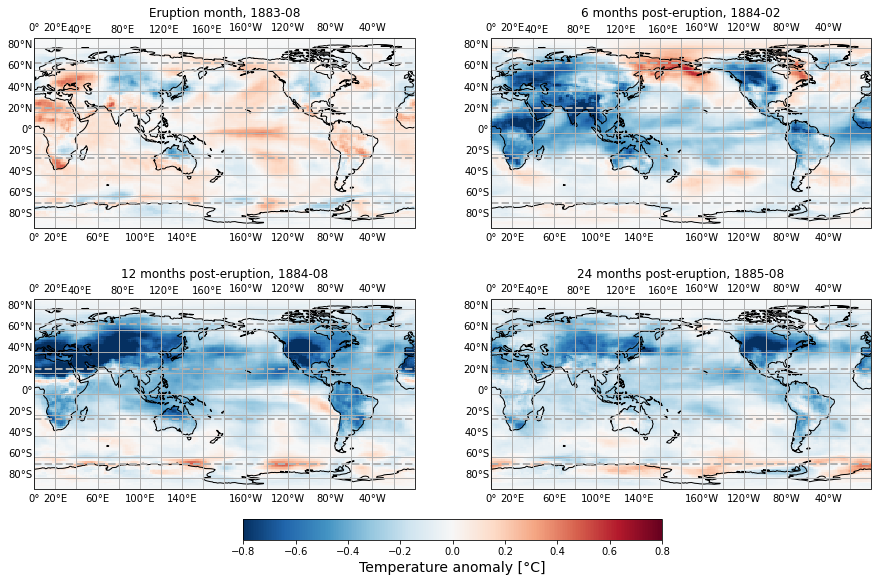

In [128]:
# plot of global monthly model mean temperature at 4 discrete time periods (not averaged)
fig = func2.spatial_plot(2, 2, K_mmm_mon_Glob.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]')

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Glob.png', dpi=300, bbox_inches='tight')

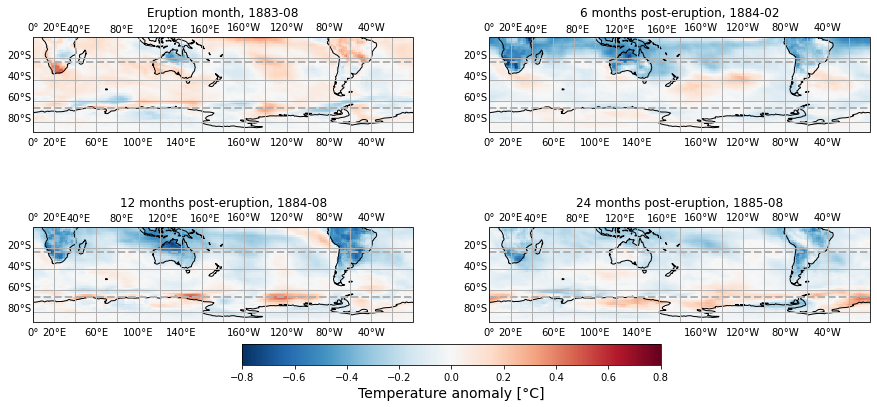

In [114]:
# plot of SH monthly model mean temperature
fig = func2.spatial_plot(2, 2, K_mmm_mon_SH.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]')

fig.set_figwidth(15)
fig.set_figheight(8) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_SH.png', dpi=300, bbox_inches='tight')

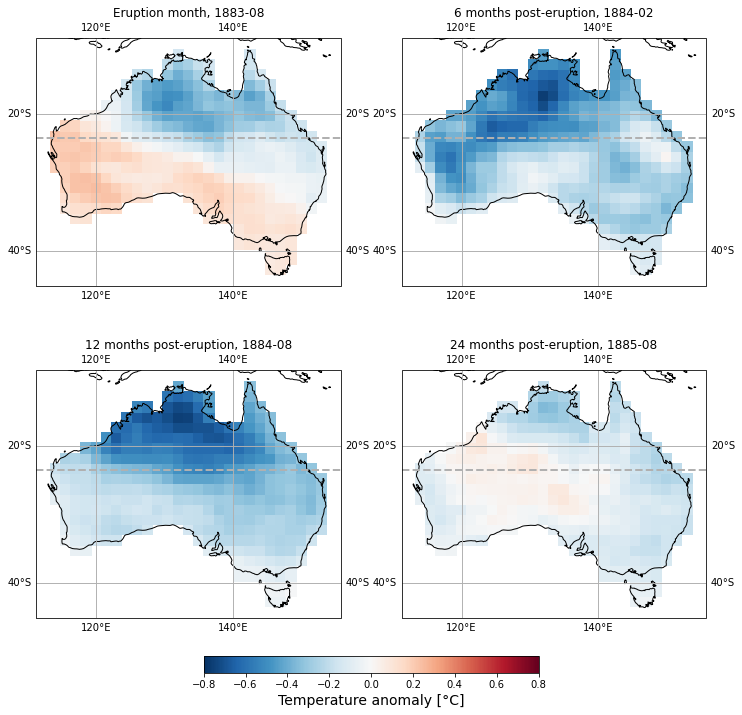

In [127]:
# plot of Aus monthly model mean temperature
fig = func2.spatial_plot(2, 2, K_mmm_mon_Aus.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]')

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_Aus.png', dpi=300, bbox_inches='tight')

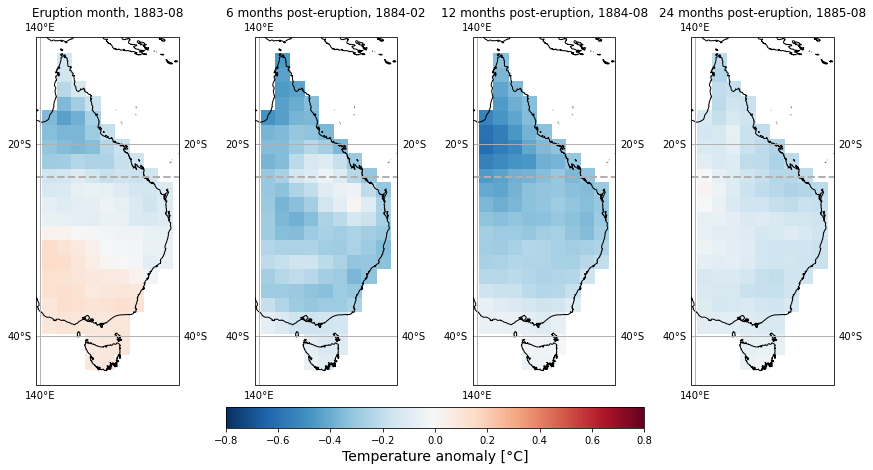

In [116]:
# plot of EA monthly model mean temperature
fig = func2.spatial_plot(1, 4, K_mmm_mon_EA.tas, cmax_tas, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]')

fig.set_figwidth(15)
fig.set_figheight(8) # these two parameters change the figure height and width 

plt.savefig('spatial_tas_EA.png', dpi=300, bbox_inches='tight')

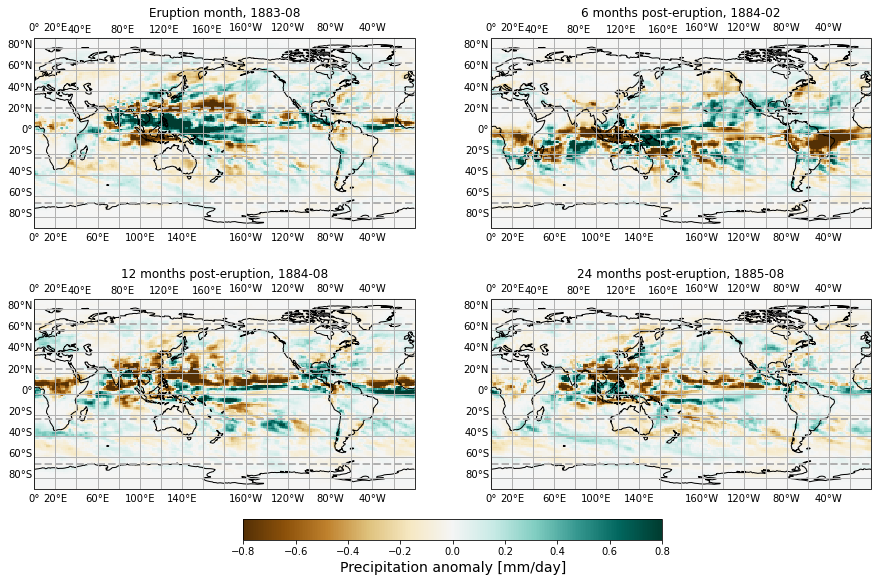

In [129]:
# plot of global monthly model mean precipitation
fig = func2.spatial_plot(2, 2, K_mmm_mon_Glob.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]')

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Glob.png', dpi=300, bbox_inches='tight')

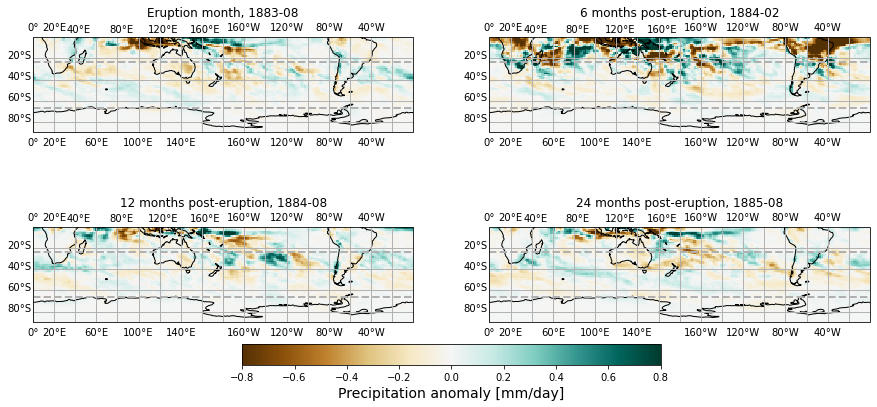

In [123]:
# plot of SH monthly model mean precipitation
fig = func2.spatial_plot(2, 2, K_mmm_mon_SH.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]')

fig.set_figwidth(15)
fig.set_figheight(8) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_SH.png', dpi=300, bbox_inches='tight')

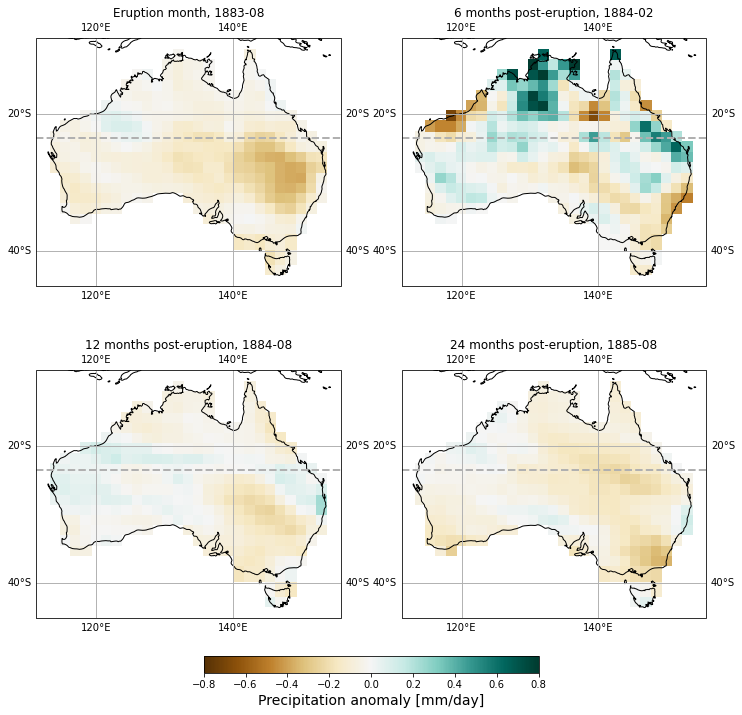

In [126]:
# plot of Aus monthly model mean precipitation
fig = func2.spatial_plot(2, 2, K_mmm_mon_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]')

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_Aus.png', dpi=300, bbox_inches='tight')

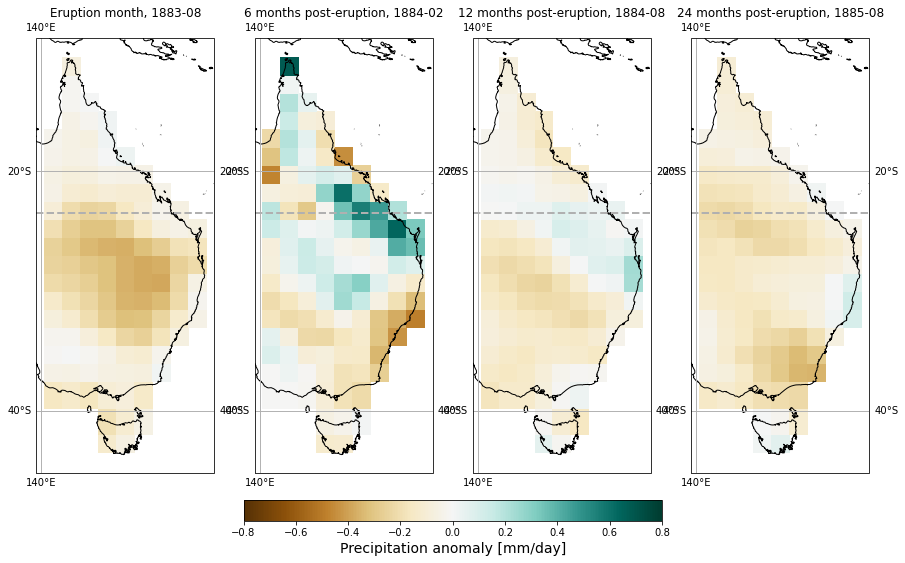

In [125]:
# plot of EA monthly model mean precipitation
fig = func2.spatial_plot(1, 4, K_mmm_mon_EA.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]')

fig.set_figwidth(15)
fig.set_figheight(10) # these two parameters change the figure height and width 

plt.savefig('spatial_pr_EA.png', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


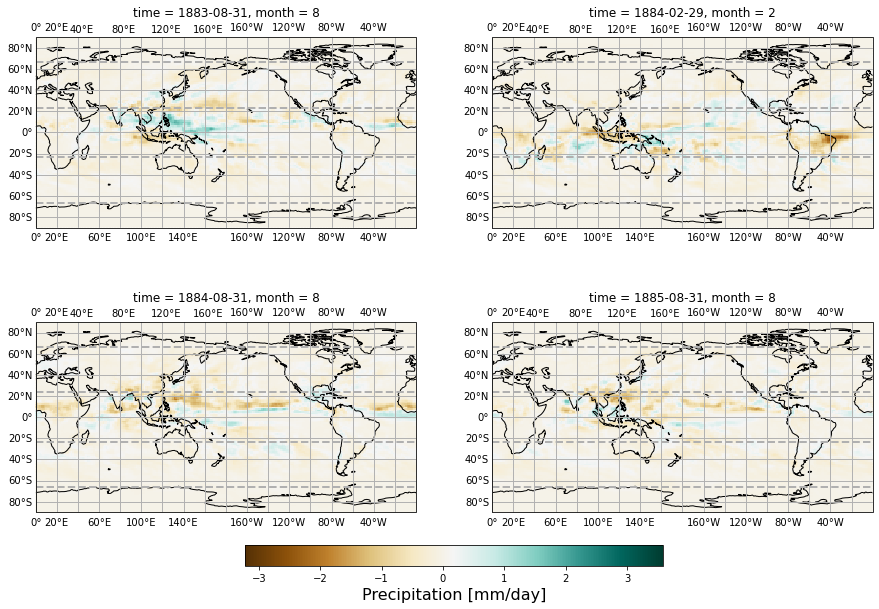

In [77]:
# use this to make any adjustments to my graphs

fig = plt.figure(figsize=(15,12))
axs = []

rows = 2
cols = 2
vmin = np.min(K_mmm_mon_Glob.pr).values
vmax = np.max(K_mmm_mon_Glob.pr).values
for i, d in enumerate(K_dates):    
    # Add a subplot with a projection    
    ax = fig.add_subplot(rows, cols, i+1, projection=ccrs.PlateCarree(180))        
    # Select the date and corresponding data and plot it    
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value    
    data = K_mmm_mon_Glob.pr.sel(time = K_dates[i])   
    C = data.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='BrBG')    
    ax.coastlines()
    # add on grid lines for longitude and latitude at specified range and spacing
    ax.gridlines(xlocs=range(-180,181,20), ylocs=range(-80,81,20),draw_labels=False) 
    ax.gridlines(xlocs=range(-160,181,20), ylocs=range(-80,81,20),draw_labels=True)
    # add in different grid lines for tropics
    tropics = ax.gridlines(ylocs=[-66.5,-23.43691,23.43691,66.5],draw_labels=False,linewidth=2,linestyle='--', edgecolor='dimgrey')
    tropics.xlines=False
    #ax.set_title(titles[i])
    #ax.xaxis.label.set_visible(False)
    ax.set_ylabel([])
    ax.xaxis.set_visible(False)

    # Gather all axes for when we make the colour bar    
    axs.append(ax)    
    

# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('Precipitation [mm/day]', fontsize=16)

fig.tight_layout()
